# SAXPY

CuPy is a GPU array backend that implements a subset of NumPy interface. NumPy runs on CPU and thus limiting speed.

You can convert CuPy array to Numpy using ```.get()```

In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def saxpy(a, x, y):
    return (a * x) + y

In [3]:
@cp.fuse()
def saxpy_fuse(a, x, y):
    return (a * x) + y

In [4]:
# Numpy
x = np.random.rand(20000000)
y = np.random.rand(20000000)

In [5]:
time_np = %timeit -o -r 3 -n 100 saxpy(1, x, y)

52.8 ms ± 77.7 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [6]:
# Cupy
x = cp.array(x)
y = cp.array(y)

In [7]:
saxpy(1, x, y)
time_cp = %timeit -o -r 3 -n 100 saxpy(1, x, y)

16.2 µs ± 237 ns per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [8]:
# Cupy fuse
time_cp_fuse = %timeit -o -r 3 -n 100 saxpy_fuse(1, x, y)

The slowest run took 561.52 times longer than the fastest. This could mean that an intermediate result is being cached.
1.44 ms ± 2.02 ms per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [9]:
# np vs cp
time_np.best / time_cp.best

3309.6668044363996

In [10]:
# np vs cp fuse
time_np.best / time_cp_fuse.best

6884.755799150333

In [11]:
# cp vs cp fuse
time_cp.best / time_cp_fuse.best

2.080196045693105

In [12]:
del x,y
cp._default_memory_pool.free_all_blocks()

In [13]:
sizes = np.arange(1000, 5_000_000, 500_000)

In [14]:
np_times = []
cp_times = []
for size in sizes:
    x = np.random.rand(size)
    y = np.random.rand(size)
    time = %timeit -o -q -r 3 -n 1 saxpy(1, x, y)
    np_times.append(time.best)
    
    x = cp.array(x)
    y = cp.array(y)
    time = %timeit -o -q -r 3 -n 1 saxpy(1, x, y)
    cp_times.append(time.best)

Text(0, 0.5, 'Computation time')

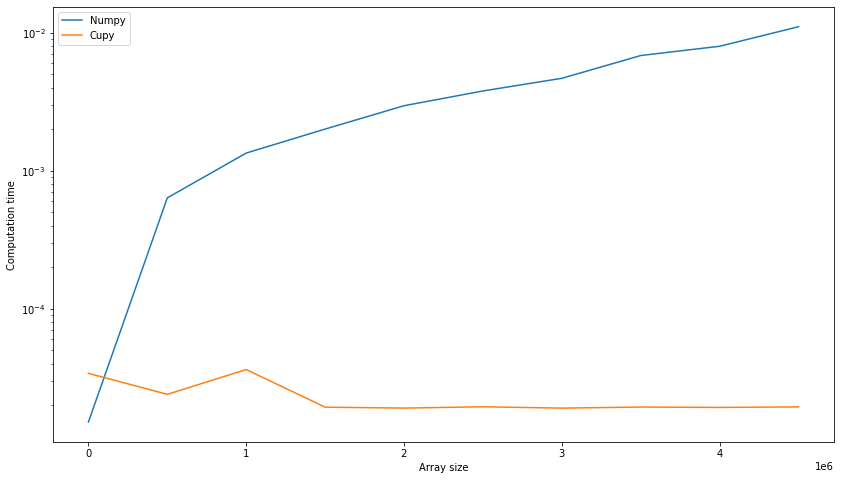

In [15]:
plt.figure(figsize=(14, 8))
plt.semilogy(sizes, np_times, label='Numpy')
plt.semilogy(sizes, cp_times, label='Cupy')
plt.legend()
plt.xlabel('Array size')
plt.ylabel('Computation time')

# CuPy-based Bifurcation map

In [16]:
def map_func(r, x):
    return r * x * (1 - x)

In [17]:
def calc_map(n, m, r, x, history):
    for _ in range(n):
        x = map_func(r, x)
    for i in range(m):
        x = map_func(r, x)
        history[:, i] = x
    return history

In [18]:
def bifurcation_map(n, m, r):
    history = np.zeros((len(r), m))
    x = np.random.uniform(size=len(r))
    return calc_map(n, m, r, x, history)

In [19]:
def bifurcation_map_cupy(n, m, r):
    history = cp.zeros((len(r), m))
    x = cp.random.uniform(size=len(r))
    return calc_map(n, m, r, x, history)

In [20]:
# Numy
r = np.linspace(0, 4, num=1000000)
time_np = %timeit -o -r 3 bifurcation_map(200, 200, r)

2.92 s ± 5.36 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [21]:
# Cupy
r_cp = cp.linspace(0, 4, num=1000000)
time_cp = %timeit -o -r 3 bifurcation_map_cupy(200, 200, r_cp)

127 ms ± 4.15 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [22]:
# np vs cp
time_np.best / time_cp.best

22.92739476978961

In [23]:
import cProfile

cProfile.run('bifurcation_map_cupy(200, 200, r_cp)')

         2622 function calls in 0.109 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.109    0.109 2559104407.py:1(bifurcation_map_cupy)
        1    0.007    0.007    0.108    0.108 2867547115.py:1(calc_map)
      400    0.100    0.000    0.101    0.000 3077998681.py:1(map_func)
      200    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(can_cast)
      400    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(min_scalar_type)
        1    0.000    0.000    0.109    0.109 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 _distributions.py:822(uniform)
        1    0.000    0.000    0.000    0.000 _generator.py:1198(get_random_state)
        1    0.000    0.000    0.000    0.000 _generator.py:1234(_check_and_get_dtype)
        1    0.000    0.000    0.000    0.000 _generator.py:598(_random_sample_raw)
        1    0.000    0.000    0.000    

In [24]:
sizes = np.arange(1_000, 5_001_000, 500_000)

In [25]:
np_time = []
mpi_time = []
cp_time = []
for size in sizes:
    r_linspace = np.linspace(0, 4, num=size)
    time = %timeit -o -q -r 2 -n 1 bifurcation_map(200, 200, r_linspace)
    np_time.append(time.best)
    
    time = %timeit -o -q -r 2 -n 1 !mpirun -n 18 python mpi.py {size}
    mpi_time.append(time.best)
    
    r_linspace = cp.array(r_linspace)
    time = %timeit -o -q -r 2 -n 1 bifurcation_map_cupy(200, 200, r_linspace)
    cp_time.append(time.best)

Text(0, 0.5, 'Computation time')

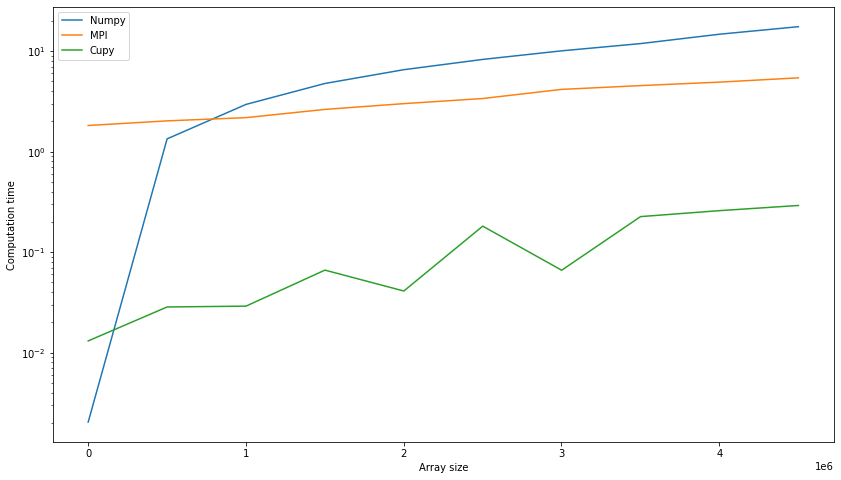

In [26]:
plt.figure(figsize=(14, 8))
plt.semilogy(sizes, np_time, label='Numpy')
plt.semilogy(sizes, mpi_time, label='MPI')
plt.semilogy(sizes, cp_time, label='Cupy')
plt.legend()
plt.xlabel('Array size')
plt.ylabel('Computation time')

# Histogram

In [27]:
def z(x):
    return cp.sin(3*x) - 0.5

def f(x):
    return (z(x)**2 + z(x)**3 - 200 * z(x)**4) * cp.sin(100000 * (x + 0.5))

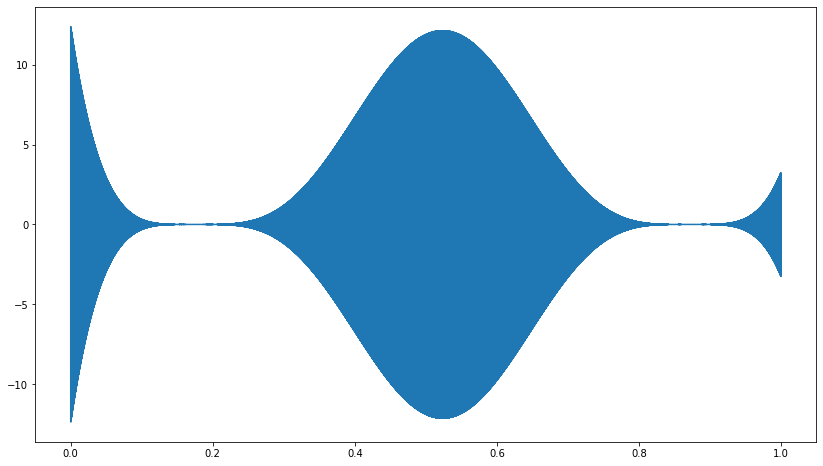

In [28]:
x = cp.linspace(0, 1, num=10_000_000)
f_x = f(x)
plt.figure(figsize=(14, 8))
plt.plot(x.get(), f_x.get())
plt.show()

In [29]:
f_min = f_x.min().get()
f_max = f_x.max().get()

In [30]:
delta = 0.1 * (f_max - f_min)

from_i = cp.arange(f_min, f_max, delta)
to_i = delta + from_i

In [31]:
counter = cp.empty(from_i.size)
for i in range(from_i.size):
    counter[i] = cp.sum((f_x >= from_i[i]) & (f_x <= to_i[i]))

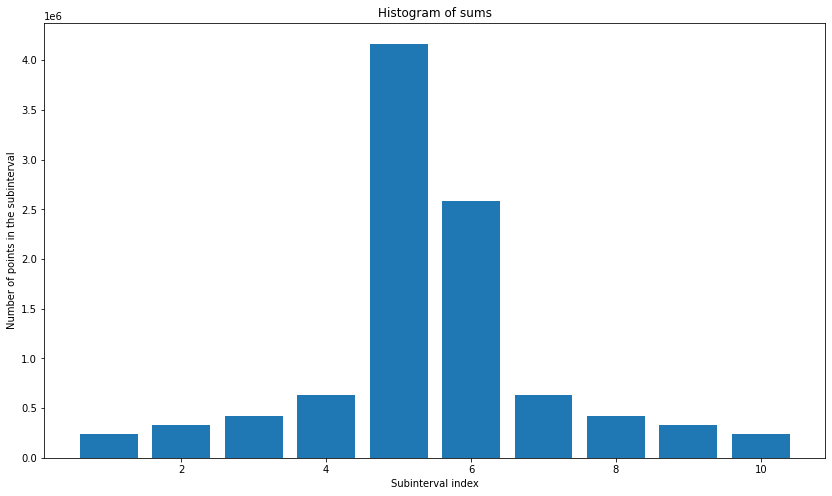

In [32]:
plt.figure(figsize=(14, 8))
plt.bar(range(1, 11), counter.get())
plt.title('Histogram of sums')
plt.xlabel('Subinterval index')
plt.ylabel('Number of points in the subinterval');
plt.show()

In [33]:
# np.sum vs cp.sum
def f():
    counter = np.empty(from_i.size)
    for i in range(from_i.size):
        counter[i] = np.sum((f_x >= from_i[i]) & (f_x <= to_i[i]))

time_np = %timeit -o -n 7 -r 10 f()

55.4 ms ± 14.9 µs per loop (mean ± std. dev. of 10 runs, 7 loops each)


In [34]:
def f():
    counter = cp.empty(from_i.size)
    for i in range(from_i.size):
        counter[i] = cp.sum((f_x >= from_i[i]) & (f_x <= to_i[i]))

time_cp = %timeit -o -n 7 -r 10 f()

The slowest run took 85.35 times longer than the fastest. This could mean that an intermediate result is being cached.
39.1 ms ± 24.7 ms per loop (mean ± std. dev. of 10 runs, 7 loops each)


In [35]:
time_np.best / time_cp.best

85.60784464693897

# Image blur

In [36]:
from PIL import Image

In [37]:
import scipy.ndimage
import cupyx.scipy.ndimage

In [38]:
def blur(img, kernel, func):
    x = img.copy()
    for i in range(3):
        x[:, :, i] = func(img[:, :, i], kernel, mode='constant')
    return x

In [39]:
SIGMA = 1

kernel_x = np.ones((5, 5)) * np.arange(-2, 3)
kernel_y = np.flip(kernel_x.T)
kernel = (1 / (2 * np.pi * SIGMA ** 2)) * \
          np.exp(-(kernel_x ** 2 + kernel_y ** 2) / (2 * SIGMA ** 2)) 

In [40]:
images = [Image.open(f'{i}.jpg') for i in range(1, 5)]

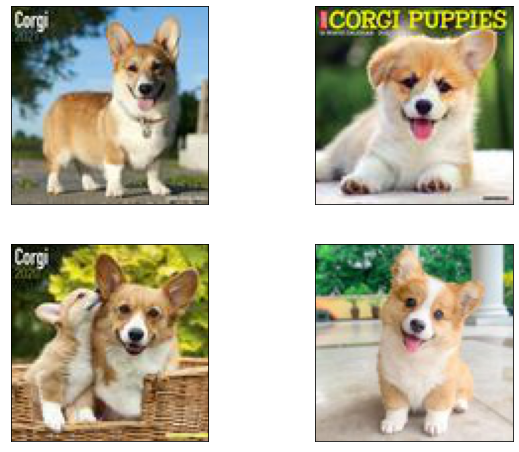

In [41]:
plt.figure(figsize=(10, 8))
for i, im in enumerate(images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])

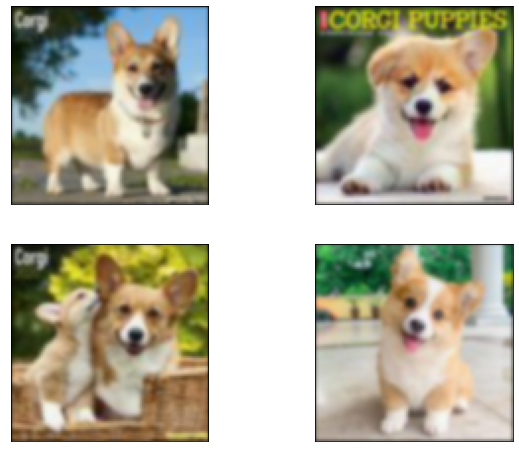

In [42]:
plt.figure(figsize=(10, 8))
for i, im in enumerate(images):
    plt.subplot(2, 2, i + 1)
    plt.imshow(blur(np.array(im), kernel, scipy.ndimage.convolve))
    plt.xticks([])
    plt.yticks([])

In [43]:
im = np.array(images[0])

In [44]:
time_np = %timeit -o -r 10 -n 10 blur(im, kernel, scipy.ndimage.convolve)

1.13 ms ± 580 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [45]:
im = cp.array(im)
kernel = cp.array(kernel)
time_cp = %timeit -o -r 10 -n 10 blur(im, kernel, cupyx.scipy.ndimage.convolve)

The slowest run took 231.71 times longer than the fastest. This could mean that an intermediate result is being cached.
6.41 ms ± 18.4 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [46]:
time_np.best / time_cp.best

2.586585295941485